In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import os

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.3.1


In [3]:
emotion_label = 'sourcils'

In [4]:
# fetch data from records
folder = f'data/landmark_records/{emotion_label}'
print(f'{folder} exists: {os.path.exists(folder)}')

data/landmark_records/sourcils exists: True


In [5]:
records_number = len(os.listdir(folder))
print(records_number)

15


In [6]:
records = []
for i in range(records_number):
    with open(f'{folder}/record_{i}.pickle','rb') as pickle_in:
        record = pickle.load(pickle_in)
    records.append(record)

In [7]:
records[0]

[(0.006598377227783203,
  array([[137, 149],
         [138, 166],
         [141, 184],
         [145, 201],
         [149, 219],
         [157, 236],
         [167, 252],
         [179, 264],
         [195, 267],
         [211, 264],
         [225, 252],
         [235, 237],
         [243, 219],
         [248, 202],
         [252, 185],
         [256, 167],
         [258, 149],
         [143, 141],
         [151, 134],
         [163, 132],
         [175, 134],
         [187, 138],
         [202, 137],
         [215, 133],
         [227, 131],
         [240, 132],
         [250, 139],
         [195, 147],
         [195, 160],
         [194, 174],
         [194, 188],
         [183, 196],
         [189, 198],
         [194, 201],
         [201, 198],
         [207, 196],
         [157, 148],
         [163, 145],
         [172, 145],
         [180, 149],
         [171, 151],
         [163, 152],
         [212, 149],
         [219, 144],
         [228, 144],
         [235, 147],
         [

In [8]:
def detail_point_id(id):
    id += 1
    if id <= 17:
        return f'contour_visage_{id}'
    if id <= 22:
        return f'sourcil_droit_{id}'
    if id <= 27:
        return f'sourcil_gauche_{id}'
    if id <= 31:
        return f'crete_nez_{id}'
    if id <= 36:
        return f'bas_nez_{id}'
    if id <= 42:
        return f'oeil_droit_{id}'
    if id <= 48:
        return f'oeil_gauche_{id}'
    if id <= 60:
        return f'levres_exterieur_{id}'
    if id <= 68:
        return f'levres_interieur_{id}'

In [9]:
LANDMARK_SIZE = 68
points_detailed_names = list(map(detail_point_id,range(LANDMARK_SIZE)))
coord_columns = [f'{point_name}_{coord}' for point_name in points_detailed_names for coord in ['x','y']]
dataset_columns = ['mu'] + coord_columns
dataset_columns_with_transform_info = ['mu', 'diameter', 'barycenter_x', 'barycenter_y'] + coord_columns

In [10]:
number_of_landmarks = sum([len(record) for record in records])
print(number_of_landmarks)

858


In [11]:
from scipy.spatial import ConvexHull
from math import sqrt

def compute_diameter(landmark):
    hull = ConvexHull(np.array(landmark))
    diameter = 0
    for i in hull.vertices:
        for j in hull.vertices:
            dist = sqrt(sum((np.array(landmark[i])-np.array(landmark[j]))**2))
            diameter = max(diameter,dist)
    return diameter

In [12]:
def normalize_landmark(landmark, transform_info = False):
    n = len(landmark)
    barycenter = sum(np.array(landmark))/n
    diameter = compute_diameter(landmark)
    normalized_landmark = ((np.array(landmark)-barycenter)/diameter).flatten()
    if transform_info:
        normalized_landmark = np.concatenate((np.array([diameter]), barycenter, normalized_landmark))
    return normalized_landmark

In [13]:
add_transform_info = False

data = np.ndarray((number_of_landmarks, 2*LANDMARK_SIZE+(4 if add_transform_info else 1)), dtype=object)
landmarks = [(mu,landmark) for record in records for mu,landmark in record]
for i, (mu,landmark) in enumerate(landmarks):
    data[i] = np.concatenate((np.array([mu]), normalize_landmark(landmark, transform_info=add_transform_info)))

In [14]:
raw_dataset = pd.DataFrame(data, columns = (dataset_columns_with_transform_info if add_transform_info else dataset_columns))

In [15]:
dataset = raw_dataset.copy()

In [16]:
dataset.isna().sum()

mu                       0
contour_visage_1_x       0
contour_visage_1_y       0
contour_visage_2_x       0
contour_visage_2_y       0
                        ..
levres_interieur_66_y    0
levres_interieur_67_x    0
levres_interieur_67_y    0
levres_interieur_68_x    0
levres_interieur_68_y    0
Length: 137, dtype: int64

In [17]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

In [18]:
train_dataset

,mu,contour_visage_1_x,contour_visage_1_y,contour_visage_2_x,contour_visage_2_y,contour_visage_3_x,contour_visage_3_y,contour_visage_4_x,contour_visage_4_y,contour_visage_5_x,...,levres_interieur_64_x,levres_interieur_64_y,levres_interieur_65_x,levres_interieur_65_y,levres_interieur_66_x,levres_interieur_66_y,levres_interieur_67_x,levres_interieur_67_y,levres_interieur_68_x,levres_interieur_68_y
144,0.54306,-0.404294,-0.224061,-0.392349,-0.110581,-0.368458,0.0088711,-0.344568,0.122351,-0.314705,...,0.0496255,0.205968,0.121297,0.21194,0.0496255,0.205968,0.0137897,0.217913,-0.0280186,0.205968
774,0.567672,-0.354889,-0.18598,-0.336168,-0.0830094,-0.298724,0.0199608,-0.26128,0.11357,-0.223836,...,0.0289088,0.197819,0.131879,0.207179,0.0382697,0.207179,0.000825965,0.21654,-0.0366178,0.21654
263,0.627444,-0.290937,-0.24666,-0.303668,-0.138448,-0.310034,-0.0302358,-0.297303,0.0843419,-0.290937,...,-0.0172241,0.186189,0.0846227,0.21165,-0.0235895,0.192554,-0.0681475,0.19892,-0.10634,0.186189
788,0.815167,-0.33968,-0.183241,-0.330381,-0.0809543,-0.293186,0.0213326,-0.265289,0.123619,-0.228094,...,0.0322723,0.19801,0.134559,0.19801,0.0415711,0.207309,-0.0049229,0.216607,-0.0421181,0.207309
847,0.833781,-0.460347,-0.334732,-0.460347,-0.200382,-0.460347,-0.0660313,-0.439134,0.0612479,-0.403779,...,0.0558406,0.230954,0.112409,0.230954,0.0558406,0.230954,0.0134142,0.238025,-0.0290122,0.230954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.0603061,-0.426621,-0.253134,-0.420272,-0.138846,-0.394875,-0.0118584,-0.375826,0.10243,-0.34408,...,0.0559304,0.210369,0.132123,0.216719,0.0559304,0.210369,0.0114849,0.216719,-0.0329607,0.210369
464,0.148524,-0.468518,-0.137689,-0.44941,-0.0230419,-0.417564,0.0916055,-0.392086,0.206253,-0.353871,...,0.066503,0.174406,0.136565,0.193514,0.0728723,0.174406,0.0282872,0.180776,-0.00992861,0.180776
25,0.460306,-0.372088,-0.231404,-0.365702,-0.12284,-0.340157,-0.00788879,-0.320998,0.100676,-0.295454,...,0.0430127,0.202854,0.106874,0.215627,0.0430127,0.209241,-0.00169045,0.215627,-0.0400074,0.209241
110,0.954091,-0.388285,-0.240353,-0.37504,-0.127773,-0.355173,-0.00857013,-0.335306,0.10401,-0.308817,...,0.0421689,0.209968,0.12826,0.21659,0.0421689,0.21659,-0.00418768,0.223213,-0.0439219,0.21659


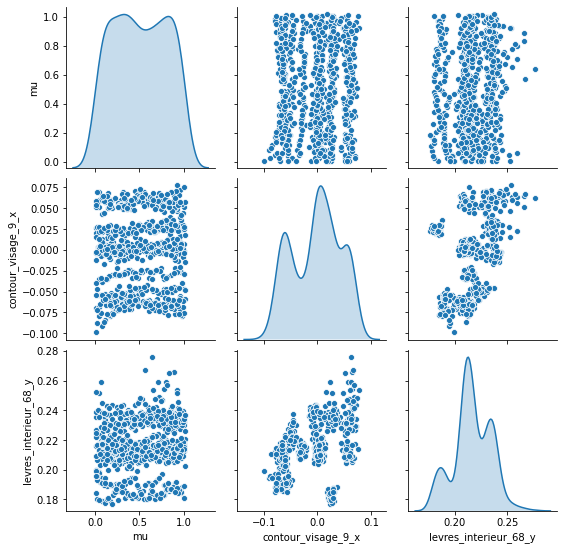

In [19]:
sns.pairplot(train_dataset[['mu','contour_visage_9_x','levres_interieur_68_y']], diag_kind='kde')

In [20]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [21]:
train_labels = train_features.pop('mu')
test_labels = test_features.pop('mu')

In [22]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
normalizer.mean.numpy()

array([-4.0439528e-01, -2.5671378e-01, -3.9964762e-01, -1.4042597e-01,
       -3.7996134e-01, -2.1339815e-02, -3.5571647e-01,  9.4747700e-02,
       -3.2293758e-01,  2.0795089e-01, -2.6948103e-01,  3.1934962e-01,
       -1.9980910e-01,  4.1641432e-01, -1.1127107e-01,  4.9175909e-01,
       -1.9363558e-03,  5.1123255e-01,  1.0593300e-01,  4.9156398e-01,
        1.9334833e-01,  4.1697133e-01,  2.6201624e-01,  3.1943733e-01,
        3.1927398e-01,  2.0951957e-01,  3.5613218e-01,  9.6161097e-02,
        3.8439554e-01, -1.8239463e-02,  4.0894225e-01, -1.3637893e-01,
        4.1706553e-01, -2.5371280e-01, -3.4965128e-01, -3.4844700e-01,
       -3.0082864e-01, -4.0371367e-01, -2.2220711e-01, -4.1519657e-01,
       -1.4128046e-01, -4.0053198e-01, -6.5455176e-02, -3.6509433e-01,
        6.0725346e-02, -3.6599651e-01,  1.4062405e-01, -4.0120968e-01,
        2.2380577e-01, -4.1698503e-01,  3.0612332e-01, -4.0373060e-01,
        3.6026064e-01, -3.4877479e-01, -6.3764164e-04, -2.7696842e-01,
      

In [23]:
def build_and_compile_model(norm = None):
    layers_seq = [
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ]
    if norm:
        layers_seq = [norm] + layers_seq
    model = keras.Sequential(layers_seq)

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [24]:
dnn_model = build_and_compile_model()

In [25]:
%%time
history = dnn_model.fit(
    np.asarray(train_features).astype(np.float32),
    np.asarray(train_labels).astype(np.float32),
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 4.45 s, sys: 259 ms, total: 4.71 s
Wall time: 3.55 s


In [26]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,val_loss
95,0.126668,0.152168
96,0.160903,0.141032
97,0.154508,0.170933
98,0.140929,0.145613
99,0.127674,0.121524


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

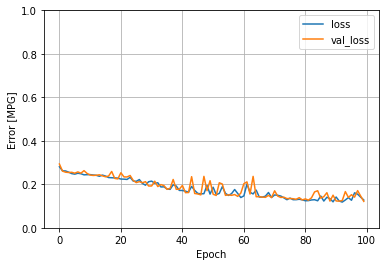

In [28]:
plot_loss(history)

In [29]:
avg_loss = dnn_model.evaluate(np.asarray(test_features).astype(np.float32),
                              np.asarray(test_labels).astype(np.float32))
print('Average loss:', avg_loss)

6/6 [==============================] - 0s 716us/step - loss: 0.1094
Average loss: 0.10941106081008911


In [30]:
dnn_model.save('mouth_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mouth_model/assets


In [31]:
def test_random_landmark():
    row = raw_dataset.sample()
    mu = row['mu'].iloc[0]
    row.pop('mu')
    landmark = np.array([np.asarray(row)[0].astype(np.float32)])
    predicted_mu = dnn_model.predict(landmark)
    print('mu:', mu)
    print('predicted_mu:', predicted_mu)

In [32]:
test_random_landmark()

mu: 0.21912436485290526
predicted_mu: [[0.11837141]]


# SVM

In [33]:
from sklearn import svm

In [34]:
train_features

,contour_visage_1_x,contour_visage_1_y,contour_visage_2_x,contour_visage_2_y,contour_visage_3_x,contour_visage_3_y,contour_visage_4_x,contour_visage_4_y,contour_visage_5_x,contour_visage_5_y,...,levres_interieur_64_x,levres_interieur_64_y,levres_interieur_65_x,levres_interieur_65_y,levres_interieur_66_x,levres_interieur_66_y,levres_interieur_67_x,levres_interieur_67_y,levres_interieur_68_x,levres_interieur_68_y
144,-0.404294,-0.224061,-0.392349,-0.110581,-0.368458,0.0088711,-0.344568,0.122351,-0.314705,0.229858,...,0.0496255,0.205968,0.121297,0.21194,0.0496255,0.205968,0.0137897,0.217913,-0.0280186,0.205968
774,-0.354889,-0.18598,-0.336168,-0.0830094,-0.298724,0.0199608,-0.26128,0.11357,-0.223836,0.21654,...,0.0289088,0.197819,0.131879,0.207179,0.0382697,0.207179,0.000825965,0.21654,-0.0366178,0.21654
263,-0.290937,-0.24666,-0.303668,-0.138448,-0.310034,-0.0302358,-0.297303,0.0843419,-0.290937,0.19892,...,-0.0172241,0.186189,0.0846227,0.21165,-0.0235895,0.192554,-0.0681475,0.19892,-0.10634,0.186189
788,-0.33968,-0.183241,-0.330381,-0.0809543,-0.293186,0.0213326,-0.265289,0.123619,-0.228094,0.216607,...,0.0322723,0.19801,0.134559,0.19801,0.0415711,0.207309,-0.0049229,0.216607,-0.0421181,0.207309
847,-0.460347,-0.334732,-0.460347,-0.200382,-0.460347,-0.0660313,-0.439134,0.0612479,-0.403779,0.188527,...,0.0558406,0.230954,0.112409,0.230954,0.0558406,0.230954,0.0134142,0.238025,-0.0290122,0.230954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.426621,-0.253134,-0.420272,-0.138846,-0.394875,-0.0118584,-0.375826,0.10243,-0.34408,0.216719,...,0.0559304,0.210369,0.132123,0.216719,0.0559304,0.210369,0.0114849,0.216719,-0.0329607,0.210369
464,-0.468518,-0.137689,-0.44941,-0.0230419,-0.417564,0.0916055,-0.392086,0.206253,-0.353871,0.308162,...,0.066503,0.174406,0.136565,0.193514,0.0728723,0.174406,0.0282872,0.180776,-0.00992861,0.180776
25,-0.372088,-0.231404,-0.365702,-0.12284,-0.340157,-0.00788879,-0.320998,0.100676,-0.295454,0.209241,...,0.0430127,0.202854,0.106874,0.215627,0.0430127,0.209241,-0.00169045,0.215627,-0.0400074,0.209241
110,-0.388285,-0.240353,-0.37504,-0.127773,-0.355173,-0.00857013,-0.335306,0.10401,-0.308817,0.223213,...,0.0421689,0.209968,0.12826,0.21659,0.0421689,0.21659,-0.00418768,0.223213,-0.0439219,0.21659


In [35]:
regr = svm.SVR()

In [36]:
regr.fit(train_features,train_labels)

SVR()

In [37]:
def test_SVR(regr, test_features_set, test_labels_set):
    predicted_labels = regr.predict(test_features_set)
    true_labels = np.asarray(test_labels_set)
    N = len(true_labels)
    return sum(list(map(lambda x: abs(x), list(true_labels-predicted_labels))))/N

In [38]:
test_SVR(regr, test_features, test_labels)

0.1580670067048898

In [39]:
import pickle
with open(f'{emotion_label}_svm.pickle','wb') as pickle_out:
    pickle.dump(regr, pickle_out)